In [3]:
# Data processing
# https://colab.research.google.com/drive/1aEFThcT0gCz3UU1ZEjgvKkAEZ-bO1E_Y#scrollTo=t1wn36PWKKx-
import pandas as pd
import numpy as np

# Modeling
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

/Users/johanneswidera/Uni/bachelorarbeit/Code/hugging-face/HUGGING_ENV/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1 Download and Clean data

In [4]:
import pandas as pd


# read in data
# read every 100th line in train.csv
df = pd.read_csv('data.csv')
df.columns = ['id', 'topic', 'mc', 'text', 'query_pattern', 'score', 'labels', 'url']


In [5]:
df.head()

,id,topic,mc,text,query_pattern,score,labels,url
0,136,The American Bar Association brings more harm ...,American Bar Association,"However, the American Bar Association does not...",q_mc,0.901,0,https://en.wikipedia.org/wiki/Certified_Paralegal
1,136,The American Bar Association brings more harm ...,American Bar Association,"In response, the American Bar Association has ...",q_mc,0.852,0,https://en.wikipedia.org/wiki/Huddleston_v._Un...
2,136,The American Bar Association brings more harm ...,American Bar Association,"However, the American Bar Association has waiv...",q_mc,0.852,0,https://en.wikipedia.org/wiki/Law_School_Admis...
3,136,The American Bar Association brings more harm ...,American Bar Association,"In 1987, the implications of the decision were...",q_mc,0.841,0,https://en.wikipedia.org/wiki/Posadas_de_Puert...
4,136,The American Bar Association brings more harm ...,American Bar Association,"In America, the American Bar Association decid...",q_cl,0.833,0,https://en.wikipedia.org/wiki/Lawyer


In [6]:
data = df[['text', 'labels']]
data.head()

,text,labels
0,"However, the American Bar Association does not...",0
1,"In response, the American Bar Association has ...",0
2,"However, the American Bar Association has waiv...",0
3,"In 1987, the implications of the decision were...",0
4,"In America, the American Bar Association decid...",0


In [7]:
argument = data['labels'] == 1
no_argument = data['labels'] == 0
print('classified as Argument: ', len(data[argument]))
print('classified as noArgument',len(data[no_argument]))

classified as Argument:  733
classified as noArgument 1766


In [8]:
# Training dataset
train_data = data.sample(frac=0.8, random_state=42)

# Testing dataset
test_data = data.drop(train_data.index)

# Step 2: Convert Pandas Dataframe to Hugging Face Dataset

In [47]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

In [48]:
# Length of the Dataset
print(f'The length of hg_train_data is {len(hg_train_data)}.\n')

# Check one review
hg_train_data[0]

The length of hg_train_data is 1999.



{'text': 'In fact, for corporate accounting, requirements and guidance contained in ISO and GHG Protocol standards are consistent and they are designed so that they can be used in a complementary manner [REF].',
 'labels': 0,
 '__index_level_0__': 2319}

# Step 3: Tokenize Text

In [49]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Take a look at the tokenizer
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [50]:
# Function to tokenize data

def tokenize_dataset(data):
    return tokenizer(data['text'], max_length=32, truncation=True, padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

In [51]:
# Take a look at the data
print(dataset_train)
print(dataset_test)
print(dataset_train[0])

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1999
})
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 500
})
{'text': 'In fact, for corporate accounting, requirements and guidance contained in ISO and GHG Protocol standards are consistent and they are designed so that they can be used in a complementary manner [REF].', 'labels': 0, '__index_level_0__': 2319, 'input_ids': [101, 1130, 1864, 117, 1111, 6214, 11438, 117, 5420, 1105, 8815, 4049, 1107, 11533, 1105, 144, 3048, 2349, 17580, 4473, 1132, 8080, 1105, 1152, 1132, 2011, 1177, 1115, 1152, 1169, 1129, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# Step 4: Load Pretraining Model



In [52]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

# Step 5: Set Training Argument

In [53]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",          
    logging_dir='./sentiment_transfer_learning_transformer/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=2,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [54]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Step 6: Train Model Using Transformer Trainer

In [55]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [56]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
 50%|█████     | 500/1000 [03:26<03:13,  2.58it/s]

{'loss': 0.5305, 'learning_rate': 2.5e-06, 'epoch': 1.0}



 50%|█████     | 500/1000 [03:36<03:13,  2.58it/s]

{'eval_loss': 0.42822450399398804, 'eval_accuracy': 0.81, 'eval_runtime': 9.446, 'eval_samples_per_second': 52.933, 'eval_steps_per_second': 13.233, 'epoch': 1.0}


100%|██████████| 1000/1000 [07:04<00:00,  2.60it/s]

{'loss': 0.3676, 'learning_rate': 0.0, 'epoch': 2.0}


                                                   
100%|██████████| 1000/1000 [07:13<00:00,  2.60it/s]

{'eval_loss': 0.4325292408466339, 'eval_accuracy': 0.806, 'eval_runtime': 9.374, 'eval_samples_per_second': 53.339, 'eval_steps_per_second': 13.335, 'epoch': 2.0}


100%|██████████| 1000/1000 [07:15<00:00,  2.29it/s]

{'train_runtime': 435.8738, 'train_samples_per_second': 9.172, 'train_steps_per_second': 2.294, 'train_loss': 0.44906768798828123, 'epoch': 2.0}


TrainOutput(global_step=1000, training_loss=0.44906768798828123, metrics={'train_runtime': 435.8738, 'train_samples_per_second': 9.172, 'train_steps_per_second': 2.294, 'train_loss': 0.44906768798828123, 'epoch': 2.0})

# Step: Evaluate Model Performance

In [57]:
trainer.evaluate(dataset_test)

100%|██████████| 125/125 [00:09<00:00, 12.96it/s]


{'eval_loss': 0.42822450399398804,
 'eval_accuracy': 0.81,
 'eval_runtime': 9.7268,
 'eval_samples_per_second': 51.404,
 'eval_steps_per_second': 12.851,
 'epoch': 2.0}

# Step 12: Save and Load Model

In [58]:
# Save tokenizer
tokenizer.save_pretrained('./argument_transfer_learning_transformer/')

# Save model
trainer.save_model('./argument_transfer_learning_transformer/')

In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./argument_transfer_learning_transformer/")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained("./argument_transfer_learning_transformer/")

from transformers import pipeline
model = pipeline('sentiment-analysis', model=loaded_model, tokenizer=tokenizer, top_k=None)

#  Step 13: INterpret with SHAP

In [10]:
import shap

/Users/johanneswidera/Uni/bachelorarbeit/Code/hugging-face/HUGGING_ENV/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/johanneswidera/Uni/bachelorarbeit/Code/hugging-face/HUGGING_ENV/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-

In [11]:
test_data.reset_index(inplace=True, drop=True)

In [20]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(test_data['text'].iloc[:2])

 34%|███▍      | 170/498 [00:10<00:00, 470.05it/s]























Partition explainer: 3it [00:37, 18.60s/it]


In [21]:
shap_values

.values =
array([array([[-0.00849229,  0.0084923 ],
              [ 0.00102324, -0.00102324],
              [-0.00518124,  0.00518125],
              [-0.00242646,  0.00242646],
              [ 0.01428808, -0.01428809],
              [ 0.01470092, -0.0147009 ],
              [-0.00979451,  0.00979449],
              [ 0.01590656, -0.01590656],
              [ 0.00637757, -0.00637757],
              [ 0.00579646, -0.00579646],
              [ 0.00035381, -0.00035382],
              [ 0.00840379, -0.00840377],
              [ 0.00435628, -0.00435628],
              [ 0.01395825, -0.01395825],
              [-0.0001314 ,  0.0001314 ],
              [ 0.01562239, -0.01562238],
              [ 0.01770297, -0.01770297],
              [ 0.00657757, -0.00657757],
              [ 0.0048072 , -0.00480719],
              [ 0.01312973, -0.01312973],
              [ 0.00550283, -0.00550283],
              [ 0.0079522 , -0.00795221],
              [ 0.00462906, -0.00462903],
              [ 0.004839

In [22]:
shap_values[1,:10, 'LABEL_1'] # first sample and Positive class 

.values =
array([ 0.01124308,  0.00940066,  0.00811196, -0.0025891 , -0.01706524,
       -0.01444625, -0.00314494, -0.00839411, -0.00136108, -0.00363914])

.base_values =
0.28298455476760864

.data =
array(['In ', 'America, ', 'the ', 'American ', 'Bar ', 'Association ',
       'decides ', 'which ', 'law ', 'schools '], dtype='<U12')

In [28]:
test_data['text'][0]

'In response, the American Bar Association has proposed to amend FRE 404 to require that prior offenses be proven by a clear and convincing standard [REF].'

shap_values is a 3 Dimensional Array,
shap_values[1,2,3]
1. which sample (say second sample -> 1)
2. how many shapley values / [tokens] of the first sample? (say all samples -> :), (say only the first 10 -> :10)
3. Which Label, Binary classificaiton 'LABEL_1' or 'LABEL_0'

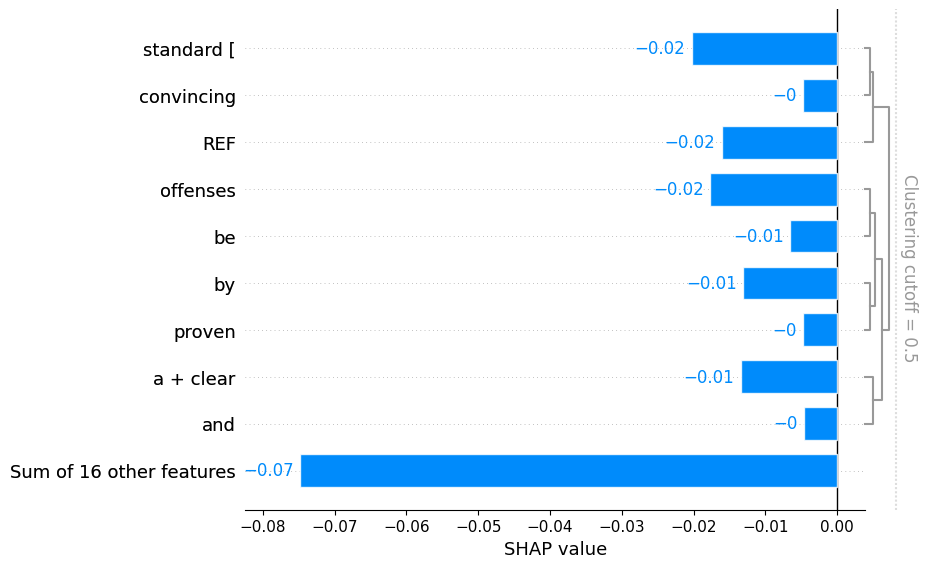

In [29]:
shap.plots.bar(shap_values[0, :, 'LABEL_1'])

In [58]:
wrong_predictions = []
for i in range(len(test_data)):
    model_prediction = model(test_data['text'][i])[0][0]['label']
    correct_value = "LABEL_" + str(test_data['labels'][i])
    print(model_prediction, correct_value)
    if correct_value != model_prediction:
        wrong_predictions.append(i)

wrong_predictions

LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_1 LABEL_0
LABEL_1 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_1 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_1 LABEL_1
LABEL_0 LABEL_1
LABEL_0 LABEL_1
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_1 LABEL_1
LABEL_1 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_1 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_0 LABEL_1
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_1
LABEL_1 LABEL_1
LABEL_0 LABEL_1
LABEL_1 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 LABEL_0
LABEL_0 

[2,
 3,
 6,
 11,
 13,
 14,
 20,
 22,
 25,
 27,
 31,
 33,
 37,
 38,
 48,
 51,
 53,
 54,
 65,
 66,
 67,
 69,
 72,
 88,
 93,
 98,
 103,
 112,
 120,
 125,
 128,
 131,
 148,
 154,
 161,
 182,
 184,
 185,
 193,
 210,
 220,
 242,
 243,
 244,
 247,
 253,
 257,
 258,
 266,
 267,
 268,
 276,
 277,
 280,
 295,
 296,
 300,
 302,
 303,
 311,
 319,
 327,
 330,
 345,
 347,
 349,
 350,
 359,
 361,
 370,
 371,
 373,
 386,
 390,
 392,
 394,
 400,
 403,
 405,
 407,
 409,
 415,
 426,
 427,
 430,
 442,
 443,
 444,
 452,
 467,
 469,
 472,
 477,
 484,
 494]

In [60]:
# find sample with indezes in wrong predictions in test_data

test_data.iloc[wrong_predictions]

,text,labels
2,The American Bar Association has found that th...,0
3,A paper in the peer reviewed Tax Lawyer journa...,0
6,The American Bar Association newsletter quickl...,0
11,"However, in many cases, it is also possible th...",1
13,The digital rights management product became a...,1
...,...,...
469,The theme being that any sort of monarchy is a...,1
472,Bokassa I attempted to justify his actions by ...,1
477,I believe conscientious objection is going to ...,0
484,Judges are increasingly recognising conscienti...,0


In [63]:
first_sample = test_data['text'][wrong_predictions[0]]
# first sample in wrong predictions
print(model(first_sample))
# text of first sample
print(first_sample)

[[{'label': 'LABEL_1', 'score': 0.785200297832489}, {'label': 'LABEL_0', 'score': 0.21479973196983337}]]
The American Bar Association has found that the evidence indicates that minority children are the most likely to suffer the negative consequences of zero tolerance policies.


## Why is the Prediction Wrong?

Correct label: 0 -> No_Argument 
BERT is only 21% sure that the Text is No_argument.
What part of the Text is responsible for the Argument_Classification?


In [65]:
shap_values = explainer([first_sample])

Partition explainer: 2it [00:20, 20.61s/it]               


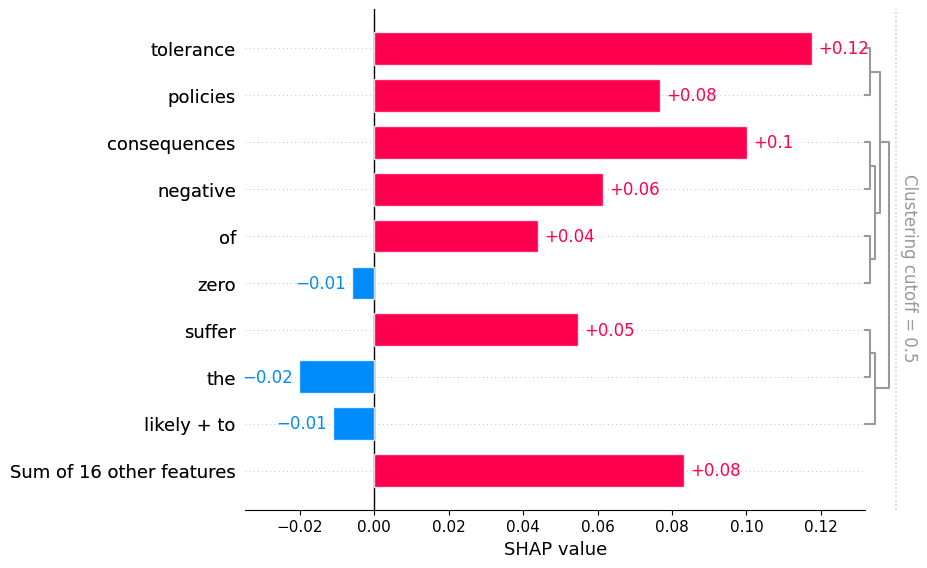

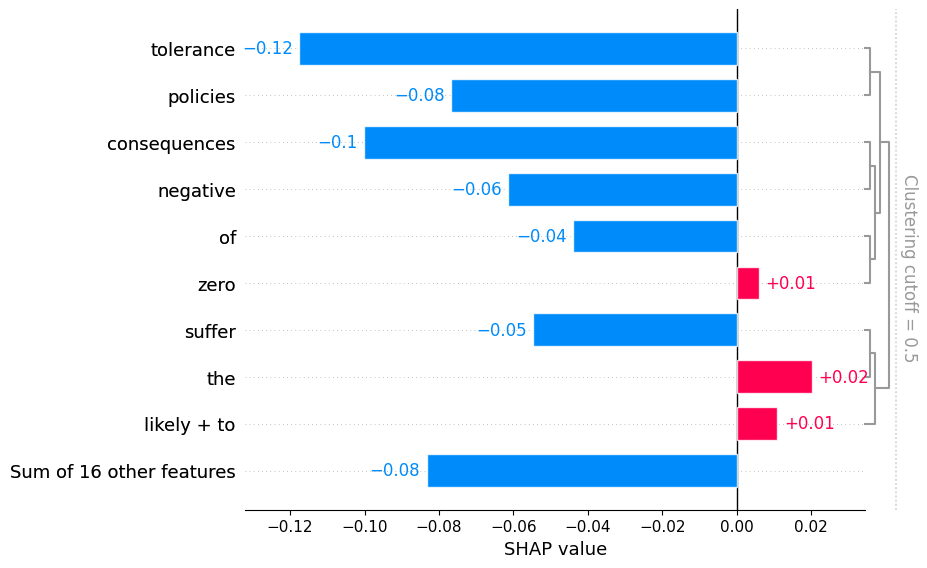

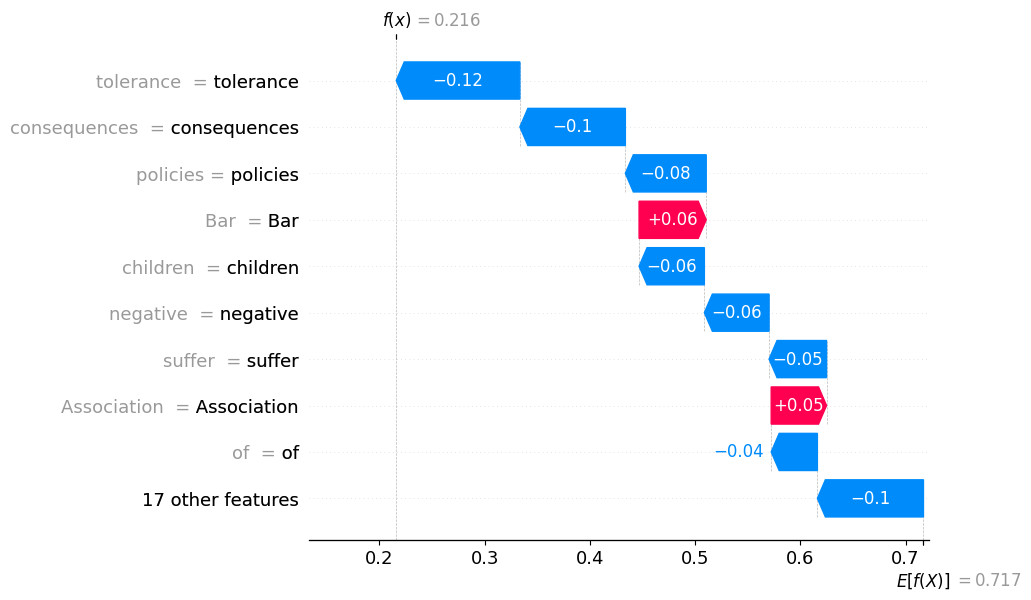

In [70]:
shap.plots.bar(shap_values[0, :, 'LABEL_1']) # towards the wrong class (LABEL_1)
shap.plots.bar(shap_values[0, :, 'LABEL_0']) # towards the correct class (LABEL_1)
shap.plots.waterfall(shap_values[0, :, 'LABEL_0']) # towards the correct class (LABEL_1)

## Interpretation
for words like 
- tolerance consequences policies Bar
The Model learned a positive impact on 'Argument LABEL'

## Wrapper function to investigate wrong Classifications

In [84]:
def investigate_wrong_classifications(index=0):
    wrong_prediction_idx = wrong_predictions[index]
    sample_text = test_data['text'][wrong_prediction_idx]
    correct_label= test_data['labels'][wrong_prediction_idx]
    print(model(sample_text))
    print(sample_text)
    print('correct label: ', correct_label)
    shap_values = explainer([sample_text])
    print('LABEL_1')
    shap.plots.bar(shap_values[0, :, 'LABEL_1']) # towards the wrong class (LABEL_1)
    shap.plots.text(shap_values[0, :, 'LABEL_1'])

[[{'label': 'LABEL_1', 'score': 0.5165131092071533}, {'label': 'LABEL_0', 'score': 0.4834868609905243}]]
The American Bar Association newsletter quickly pointed out possible adverse consequences for Indian gaming and tribal sovereignty.
correct label:  0














Partition explainer: 2it [00:11, 11.02s/it]               


LABEL_1


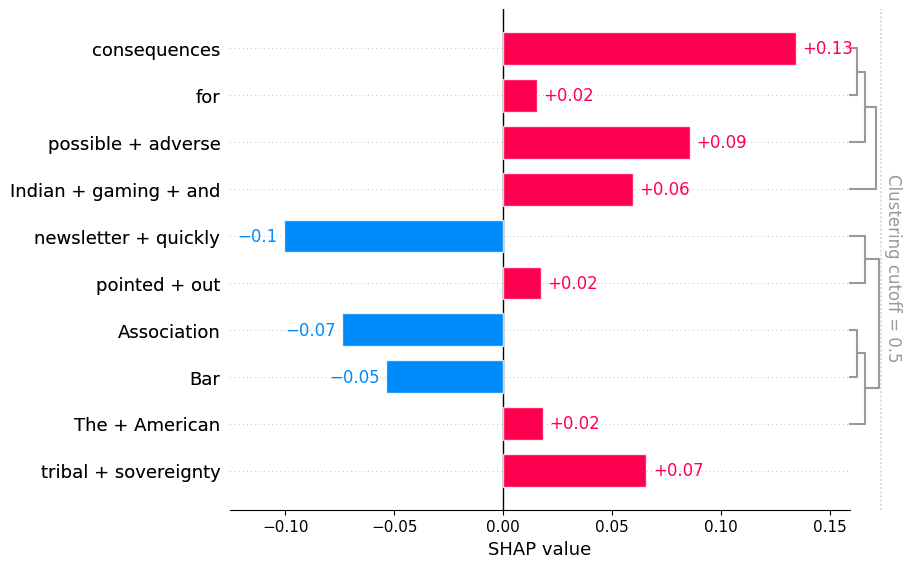

In [85]:
investigate_wrong_classifications(2)

[[{'label': 'LABEL_0', 'score': 0.9062768220901489}, {'label': 'LABEL_1', 'score': 0.0937231257557869}]]
However, in many cases, it is also possible that digital rights management will result in the complete denial of access by the purchaser to the e-book [REF].
correct label:  1


























































Partition explainer: 2it [00:23, 23.21s/it]               

LABEL_1


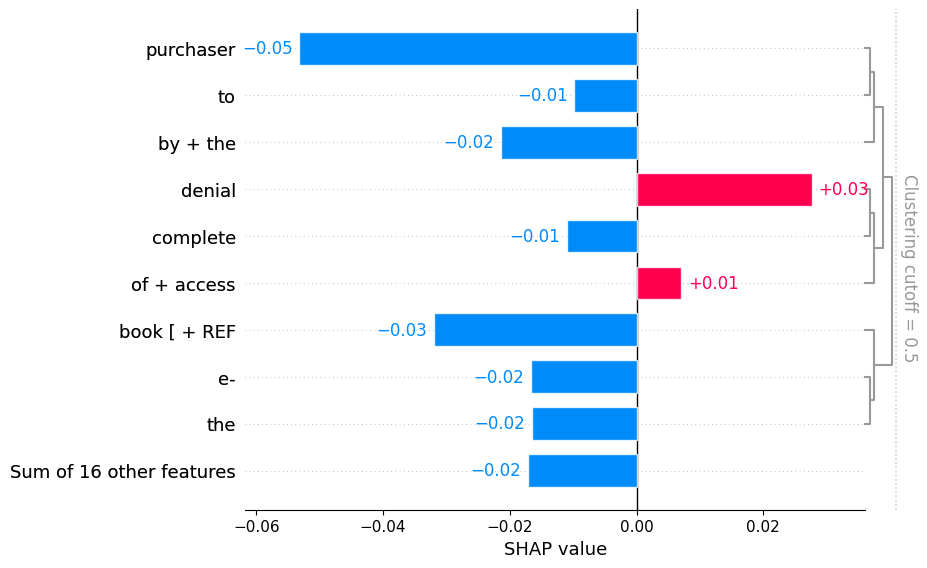

In [86]:
investigate_wrong_classifications(3)

## Try Different Masker

[[{'label': 'LABEL_0', 'score': 0.9062768220901489}, {'label': 'LABEL_1', 'score': 0.0937231257557869}]]
However, in many cases, it is also possible that digital rights management will result in the complete denial of access by the purchaser to the e-book [REF].
correct label:  1
LABEL_1


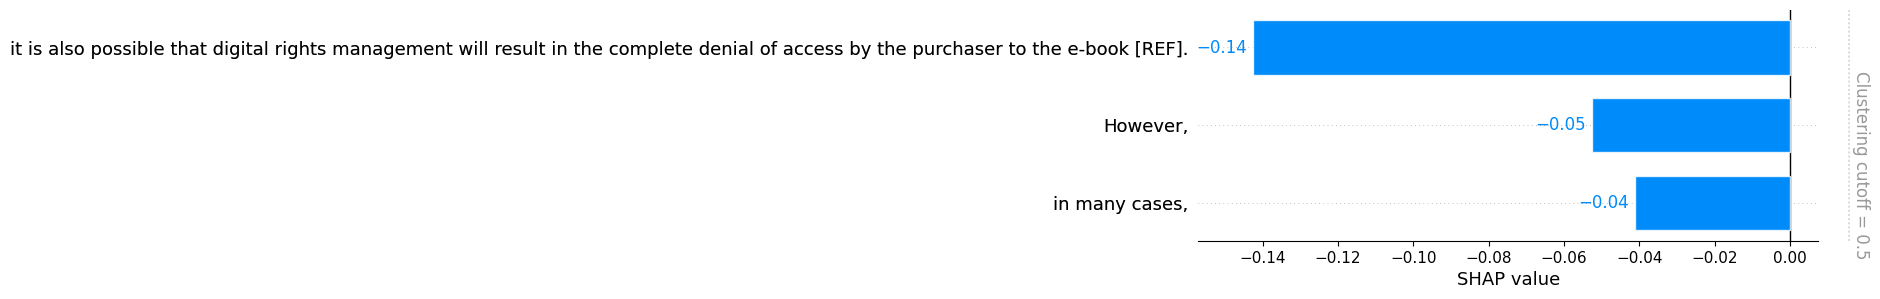

In [90]:
masker = shap.maskers.Text(
  tokenizer=r"\,", mask_token=' ', collapse_mask_token=True
)
explainer = shap.Explainer(model, masker=masker)

investigate_wrong_classifications(3)

[[{'label': 'LABEL_0', 'score': 0.9062768220901489}, {'label': 'LABEL_1', 'score': 0.0937231257557869}]]
However, in many cases, it is also possible that digital rights management will result in the complete denial of access by the purchaser to the e-book [REF].
correct label:  1
LABEL_1


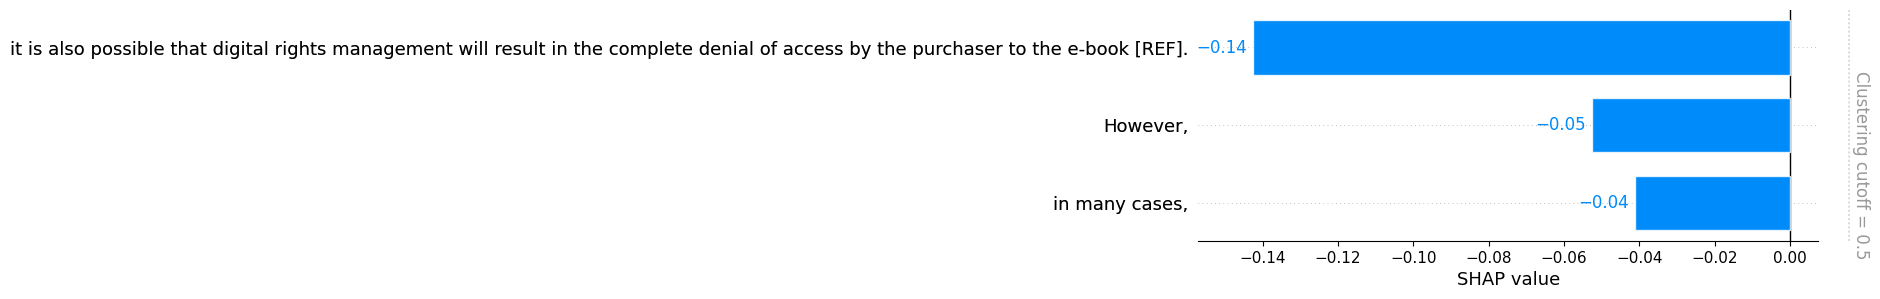

In [92]:
masker = shap.maskers.Text(
  tokenizer=r"\,", mask_token=' ', collapse_mask_token=True
)
explainer = shap.Explainer(model, masker=masker)

investigate_wrong_classifications(3)

[[{'label': 'LABEL_0', 'score': 0.9062768220901489}, {'label': 'LABEL_1', 'score': 0.0937231257557869}]]
However, in many cases, it is also possible that digital rights management will result in the complete denial of access by the purchaser to the e-book [REF].
correct label:  1
























































Partition explainer: 2it [00:22, 22.61s/it]               


LABEL_1


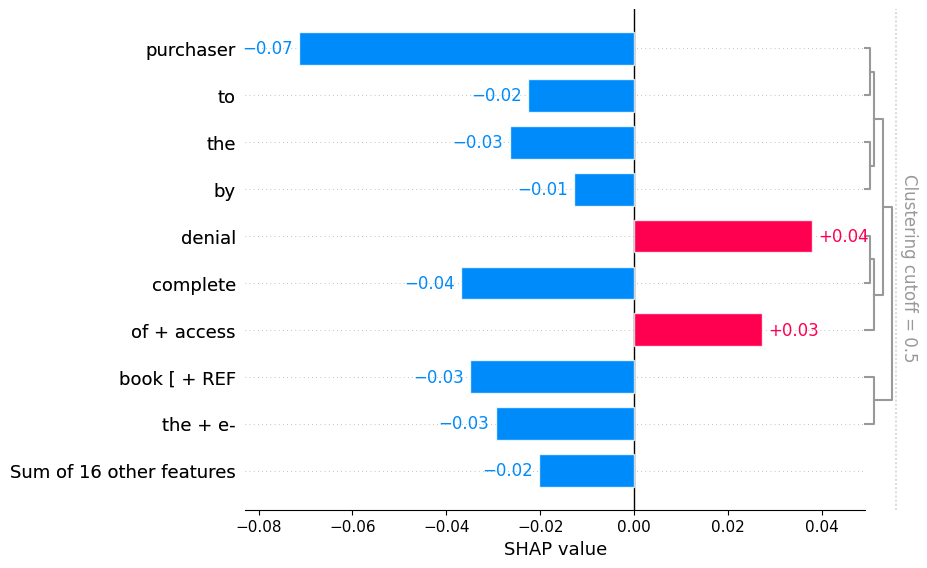

In [93]:
masker = shap.maskers.Text(
  tokenizer=r"\W+", mask_token=' ', collapse_mask_token=True
)
explainer = shap.Explainer(model, masker=masker)

investigate_wrong_classifications(3)